**Cas 1 :** Si on a deux classes à prédire (chats vs chiens) et des millions d'images pour chaque classe alors un CNN classique sera un meilleur choix pour la classification.  
**Cas 2 :** Mais si on a des milliers de classes à prédire et quelques dizaine d'images. Alors, un réseau CNN classique va être un mauvais choix.  
## Les réseaux siamois :
**Définition:**    
Un réseau de neurones siamois se compose de deux sous-réseaux identiques, joints à leurs sorties. Les deux sous-réseaux partagent également les mêmes poids. Ils travaillent en parallèle et sont chargés de créer des représentations vectorielles pour les entrées.  
Par exemple, nous pouvons utiliser un $ResNet$ comme sous-réseau si nos entrées sont des images.  
Le réseau aide à produire de meilleures représentations vectorielles en mesurant les similitudes entre les vecteurs.  
**Principe:**
- Utiliser des couches convolutionnels pour extraire des caractéristiques.L'output serait un vecteur de dimension inférieur.
- Utiliser la distance euclidienne, pour mesure la différence entre les deux vecteurs output des couches convolutionnels.



In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
import numpy as np
import os
import tensorflow as tf
from keras.preprocessing.image import load_img, img_to_array
from keras.models import Sequential, Input
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from keras import backend as K
import matplotlib.pyplot as plt
import random
from keras.layers import Lambda

**Dataset :**
On a 40 visages différents.  
Chaque visage a 10 images.

In [ ]:

faces_dir = '/content/gdrive/My Drive/datasets/faces-dataset/'

X_train, Y_train = [], []
X_test, Y_test = [], []
subfolders = sorted([file.path for file in os.scandir(faces_dir) if file.is_dir()])
for idx, folder in enumerate(subfolders):
    for file in sorted(os.listdir(folder)):
        img = load_img(folder+"/"+file, color_mode='grayscale')
        img = img_to_array(img).astype('float32')/255
        img = img.reshape(img.shape[0], img.shape[1],1)
        if idx < 35:
            X_train.append(img)
            Y_train.append(idx)
        else:
            X_test.append(img)
            Y_test.append(idx-35)


X_train = np.array(X_train)
X_test = np.array(X_test)
Y_train = np.array(Y_train)
Y_test = np.array(Y_test)


**Exemple du subject N° 6:**

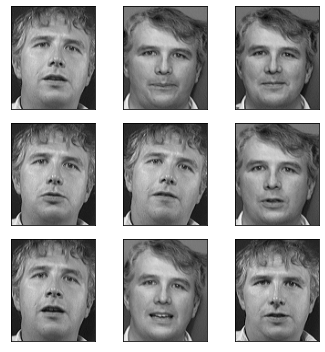

In [ ]:
subject_idx = 6
fig, ((ax1,ax2,ax3),(ax4,ax5,ax6),(ax7,ax8,ax9)) = plt.subplots(3,3,figsize=(5,5))
subject_img_idx = np.where(Y_train==subject_idx)[0].tolist()
for i, ax in enumerate([ax1,ax2,ax3,ax4,ax5,ax6,ax7,ax8,ax9]):
    img = X_train[subject_img_idx[i]]
    img = np.squeeze(img)
    ax.imshow(img, cmap='gray')
    ax.grid(False)
    ax.set_xticks([])
    ax.set_yticks([])
plt.tight_layout()
plt.show()

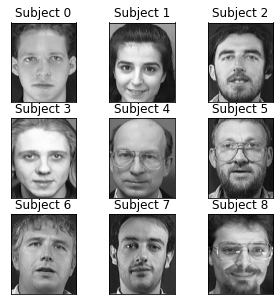

<Figure size 432x288 with 0 Axes>

In [ ]:
# Plot the first 9 subjects
subjects = range(10)
fig, ((ax1,ax2,ax3),(ax4,ax5,ax6),
      (ax7,ax8,ax9)) = plt.subplots(3,3,figsize=(5,5))
subject_img_idx = [np.where(Y_train==i)[0].tolist()[0] for i in subjects]
for i, ax in enumerate([ax1,ax2,ax3,ax4,ax5,ax6,ax7,ax8,ax9]):
    img = X_train[subject_img_idx[i]]
    img = np.squeeze(img)
    ax.imshow(img, cmap='gray')
    ax.grid(False)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_title("face {}".format(i))
plt.show()
plt.tight_layout()

**Création du modèle partagé:**

![](https://drive.google.com/uc?id=1yn4uJ7O2O58eULbDmTAAus1cG5YSYYJb)

In [ ]:
def create_shared_network(input_shape):
  model = Sequential(name='Shared_Conv_Network')
  model.add(Conv2D(filters=64, kernel_size=(3,3), activation='relu', input_shape=input_shape))
  model.add(MaxPooling2D())
  model.add(Conv2D(filters=64, kernel_size=(3,3), activation='relu'))
  model.add(Flatten())
  model.add(Dense(units=128, activation='sigmoid'))
  return model

![](https://drive.google.com/uc?id=1D2CwgRQKq8Q1zYFeX8u2iLpVWh-SRV3S)

In [ ]:
input_shape = X_train.shape[1:]
shared_network = create_shared_network(input_shape)
# input top and input bottom
input_top = Input(shape=input_shape)
input_bottom = Input(shape=input_shape)
# output top and output bottom
output_top = shared_network(input_top)
output_bottom = shared_network(input_bottom)


In [ ]:
def euclidean_distance(vectors):
  vector1, vector2 = vectors
  sum_square = K.sum(K.square(vector1 - vector2), axis=1, keepdims=True)
  return K.sqrt(K.maximum(sum_square, K.epsilon()))

Puisqu'il n y'a pas une couche dans $Keras$ qui permet de calculer la distance euclidienne entre deux vecteurs.  
On définit notre propre couche. La couche $Lambda$ de $Keras$ permet d'inclure une fonction arbitraire comme un objet de type $Layer$.
 

In [ ]:
distance = Lambda(euclidean_distance, output_shape=(1,), name='Euclidean_distance')([output_top,
output_bottom])

In [ ]:
from keras.models import Model

model = Model(inputs=[input_top, input_bottom], outputs=distance)
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 112, 92, 1)] 0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 112, 92, 1)] 0                                            
__________________________________________________________________________________________________
Shared_Conv_Network (Sequential (None, 128)          18707264    input_1[0][0]                    
                                                                 input_2[0][0]                    
__________________________________________________________________________________________________
Euclidean_distance (Lambda)     (None, 1)            0           Shared_Conv_Network[0][0]    

**On essaye de créer des paires d'images positives et négatives pour entrainer notre modèle:**

In [ ]:
def create_pairs(X,Y, num_classes):
  pairs, labels = [], []
  # index of images in X and Y for each class
  class_idx = [np.where(Y==i)[0] for i in range(num_classes)]
  # The minimum number of images across all classes
  min_images = min(len(class_idx[i]) for i in range(num_classes)) - 1
  for c in range(num_classes):
    for n in range(min_images):
          # create positive pair
          img1 = X[class_idx[c][n]]
          img2 = X[class_idx[c][n+1]]
          pairs.append((img1, img2))
          labels.append(1)
          # create negative pair
          neg_list = list(range(num_classes))
          neg_list.remove(c)
          # select a random class from the negative list.
          # this class will be used to form the negative pair
          neg_c = random.sample(neg_list,1)[0]
          img1 = X[class_idx[c][n]]
          img2 = X[class_idx[neg_c][n]]
          pairs.append((img1,img2))
          labels.append(0)
  return np.array(pairs), np.array(labels)

In [ ]:
num_classes = len(np.unique(Y_train))
training_pairs, training_labels = create_pairs(X_train, 
                                              Y_train,
                                               len(np.unique(Y_train))
                                              )


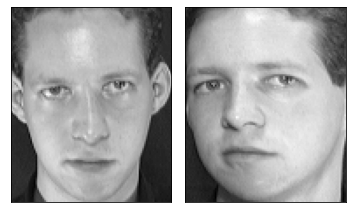

In [ ]:
from keras.preprocessing.image import array_to_img
#img = array_to_img(training_pairs[0][0])
#plt.imshow(img, cmap='gray')
fig, (ax1,ax2) = plt.subplots(1,2,figsize=(5,5))
for i, ax in enumerate([ax1,ax2]):
    img = array_to_img(training_pairs[6][i])
    ax.imshow(img, cmap='gray')
    ax.grid(False)
    ax.set_xticks([])
    ax.set_yticks([])
plt.tight_layout()
plt.show()

In [ ]:
test_pairs, test_labels = create_pairs(X_test, Y_test, len(np.unique(Y_test)))

On définit une fonction de perte (loss) avant le commencer l'entrainement du modèle.  
**Contrastive Loss:**
_______________________________  
$Contrastive Loss $ = $Y_{true}*D^{2} + (1 - Y_{true})*max
(margin-D, 0)$
_______________________________
$Y_{true} : 1$ si same face  
$Y_{true} : 0$ sinon  
$D : $ La distance output prédite


In [ ]:
def contrastive_loss(Y_true, D):
  Y_true = tf.cast(Y_true, tf.float32)
  margin = 1
  return K.mean(Y_true*K.square(D)+(1 - Y_true)*K.maximum((margin-D),0))

def accuracy_siam(y_true, y_pred):
    return K.mean(K.equal(y_true, K.cast(y_pred < 0.5, y_true.dtype)))


In [ ]:
model.compile(loss=contrastive_loss, optimizer='adam', metrics=[accuracy_siam])

In [ ]:
model.fit( [training_pairs[:,0], training_pairs[:,1]], 
            training_labels,
            batch_size=128, 
            epochs=10)

Epoch 1/10
5/5 [==============================] - 29s 5s/step - loss: 0.3394 - accuracy_siam: 0.6873
Epoch 2/10
5/5 [==============================] - 27s 5s/step - loss: 0.1141 - accuracy_siam: 0.8991
Epoch 3/10
5/5 [==============================] - 27s 5s/step - loss: 0.0755 - accuracy_siam: 0.9635
Epoch 4/10
5/5 [==============================] - 27s 5s/step - loss: 0.0539 - accuracy_siam: 0.9968
Epoch 5/10
5/5 [==============================] - 27s 5s/step - loss: 0.0321 - accuracy_siam: 1.0000
Epoch 6/10
5/5 [==============================] - 27s 5s/step - loss: 0.0223 - accuracy_siam: 1.0000
Epoch 7/10
5/5 [==============================] - 27s 5s/step - loss: 0.0200 - accuracy_siam: 1.0000
Epoch 8/10
5/5 [==============================] - 27s 5s/step - loss: 0.0169 - accuracy_siam: 1.0000
Epoch 9/10
5/5 [==============================] - 27s 5s/step - loss: 0.0109 - accuracy_siam: 1.0000
Epoch 10/10
5/5 [==============================] - 27s 5s/step - loss: 0.0102 - accuracy_si

In [ ]:
idx1, idx2 = 21,25
img1 = np.expand_dims(X_test[idx1], axis=0)
img2 = np.expand_dims(X_test[idx2], axis=0)

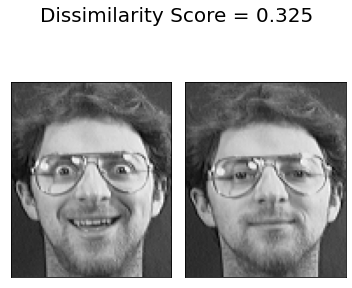

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(5,5))
ax1.imshow(np.squeeze(img1), cmap='gray')
ax2.imshow(np.squeeze(img2), cmap='gray')
for ax in [ax1, ax2]:
    ax.grid(False)
    ax.set_xticks([])
    ax.set_yticks([])
dissimilarity = model.predict([img1, img2])[0][0]
fig.suptitle("Dissimilarity Score = {:.3f}".format(dissimilarity), size=20)
plt.tight_layout()
plt.show()